# Model Analysis

This notebook will analyze the training results of the standard and balanced model on the [imbalanced insurance](https://www.kaggle.com/arashnic/imbalanced-data-practice) dataset. In order for the cells in this notebook to run, you must first run the following command to train the models:
```
python model_training.py
```

## Import required libraries

In [226]:
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

## Learning Curves

### Create Plotting Data Function 

In [227]:
def create_plot_ready_data(list_of_train_stats, model_names, metric, target):
    # List of splits to evaluate statistics for
    list_of_splits = ['training', 'validation', 'test']    
    
    # Empty list to fill with dfs for each models' stats
    list_of_train_stats_df = []
    
    # For each models' stats, create a df with columns of stats for each split listed above
    for name, stats in zip(model_names, list_of_train_stats):
        list_of_dfs = []
        for split in list_of_splits:
                df = pd.DataFrame(stats[split][target])
                df.columns = [split + '_' + c for c in df.columns]
                list_of_dfs.append(df)
    
        combined_df = pd.concat(list_of_dfs, axis=1)
        combined_df.name = name
        combined_df['epoch'] = combined_df.index + 1
        list_of_train_stats_df.append(combined_df)
    
    # holding ready for plot ready data
    plot_ready_list = []
    
    # consolidate the multiple training statistics dataframes
    for df in list_of_train_stats_df:
        for col in ['training', 'validation']:
            df2 = df[['epoch', col + '_{}'.format(metric)]].copy()
            df2.columns = ['epoch', '{}'.format(metric)]
            df2['split'] = col
            df2['model'] = df.name
            plot_ready_list.append(df2)

    return pd.concat(plot_ready_list, axis=0, ignore_index=True)

### Create Plotting Data

In [228]:
standard_stats = load_json(os.path.join('results/balance_example_standard_model','training_statistics.json'))
balanced_stats = load_json(os.path.join('results/balance_example_balanced_model','training_statistics.json'))

accuracy_learning_curves = create_plot_ready_data([standard_stats, balanced_stats], ['standard_model', 'balanced_model'], 'accuracy', 'Response')
roc_auc_learning_curves = create_plot_ready_data([standard_stats, balanced_stats], ['standard_model', 'balanced_model'], 'roc_auc', 'Response')
loss_learning_curves = create_plot_ready_data([standard_stats, balanced_stats], ['standard_model', 'balanced_model'], 'loss', 'Response')

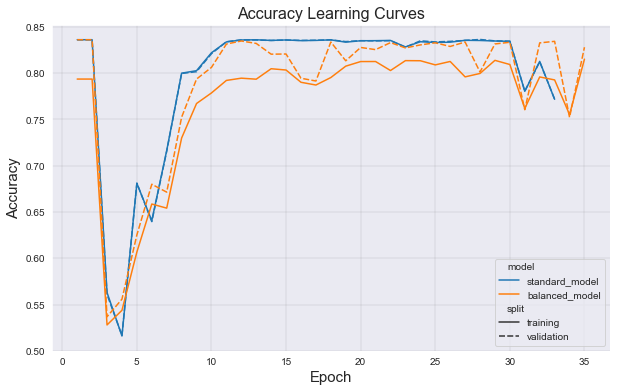

In [229]:
fig = plt.figure(figsize=(10,6))
sns.set_style(style='dark')
ax = sns.lineplot(x='epoch', y='accuracy',
             style='split',
             hue='model',
             data=accuracy_learning_curves)
ax.set_title('Accuracy Learning Curves', fontdict={'fontsize': 16})
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.grid(visible=True, which='minor', color='black', linewidth=0.075)
ax.set_xlabel("Epoch", fontsize = 15)
ax.set_ylabel("Accuracy", fontsize = 15);

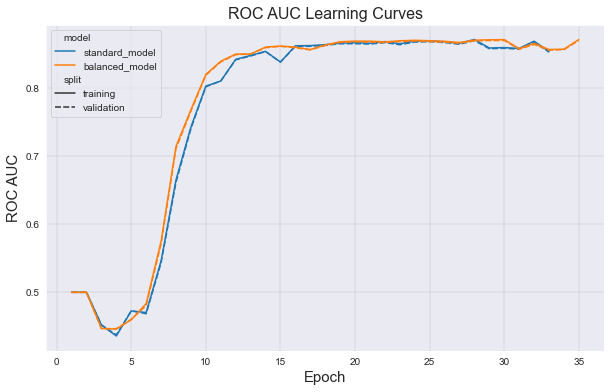

In [230]:
fig = plt.figure(figsize=(10,6))
sns.set_style(style='dark')
ax = sns.lineplot(x='epoch', y='roc_auc',
             style='split',
             hue='model',
             data=roc_auc_learning_curves)
ax.set_title('ROC AUC Learning Curves', fontdict={'fontsize': 16})
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.grid(visible=True, which='minor', color='black', linewidth=0.075)
ax.set_xlabel("Epoch", fontsize = 15)
ax.set_ylabel("ROC AUC", fontsize = 15);

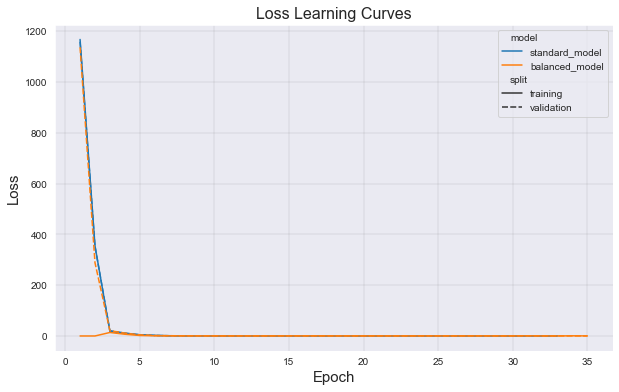

In [231]:
fig = plt.figure(figsize=(10,6))
sns.set_style(style='dark')
ax = sns.lineplot(x='epoch', y='loss',
             style='split',
             hue='model',
             data=loss_learning_curves)
ax.set_title('Loss Learning Curves', fontdict={'fontsize': 16})
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.grid(visible=True, which='minor', color='black', linewidth=0.075)
ax.set_xlabel("Epoch", fontsize = 15)
ax.set_ylabel("Loss", fontsize = 15);